In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial import Delaunay

# $f\left(x,y\right) = x^2 + y^2$

In [3]:
def f(x, y):
    return  x**2 + y**2

# Version 1: right triangles

In [19]:
y_steps, x_steps = 20, 20
y_start, y_end = -2, 2
x_start, x_end = -2, 2

In [20]:
triangle1 = torch.tensor([[x_start, y_start]]) + torch.tensor([
[0, 0],
[0, 1],
[1, 0]
]) * torch.tensor([[(x_end-x_start)/x_steps, (y_end-y_start)/y_steps]])
triangle2 = torch.tensor([[x_start, y_start]]) + torch.tensor([
[1, 0],
[1, 1],
[0, 1]
])  * torch.tensor([[(x_end-x_start)/x_steps, (y_end-y_start)/y_steps]])

In [21]:
triangles = []
for stepy in range(y_steps):
    for stepx in range(x_steps):
        shift = torch.tensor([(x_end - x_start)/x_steps*stepx,(y_end - y_start)/y_steps*stepy])
        triangles.append(triangle1 + shift)
        triangles.append(triangle2 + shift)        
triangles_s = torch.stack(triangles)
triangles_c = torch.cat(triangles)

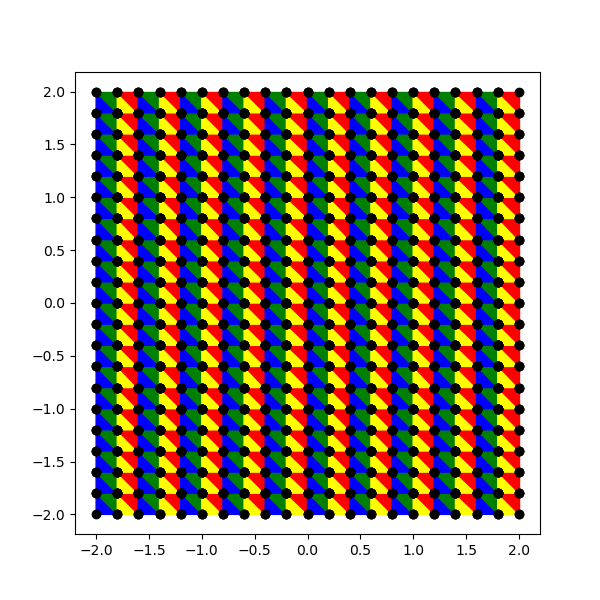

In [22]:
colors = ["red", "blue", "green", "yellow"]
l = len(colors)
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("equal")
for index, triangle in enumerate(triangles_s, 1):
    t1 = plt.Polygon(triangle, color=colors[index%l])
    plt.gca().add_patch(t1)
ax.scatter(triangles_c[:, 0], triangles_c[:, 1], color="black")
plt.show()

# Version 2: Delaunay triangulrization of given points

In [8]:
points = (numpy.mgrid[0:11, 0:11].transpose(1, 2, 0) - numpy.array([[[5, 5]]])).reshape(-1, 2)/2.5

In [9]:
r2 = points[:, 0]**2 + points[:, 1]**2

In [10]:
points = points[(r2 <= 4)]

In [11]:
triangles_s = torch.from_numpy(points[Delaunay(points, ).simplices])
triangles_c = triangles_s.reshape(-1, 2)

# Delaunay

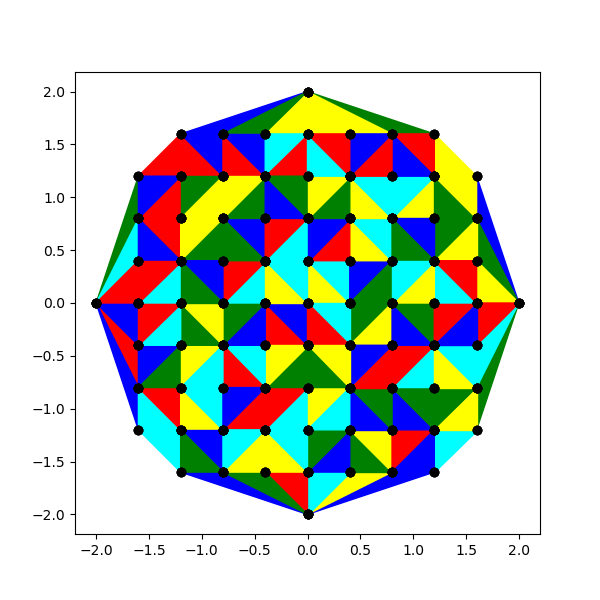

In [603]:
colors = ["red", "blue", "green", "yellow", "cyan"]
l = len(colors)
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("equal")
for index, triangle in enumerate(triangles_s, 1):
    t1 = plt.Polygon(triangle, color=colors[index%l])
    plt.gca().add_patch(t1)
ax.scatter(triangles_c[:, 0], triangles_c[:, 1], color="black")
plt.show()

# Preprocessing part

In [23]:
tx = torch.linspace(-2, 2, 100)
ty = torch.linspace(-2, 2, 100)
xx, yy = torch.meshgrid(tx, ty, indexing="xy")
points_ = torch.stack((xx, yy)).permute(1, 2, 0)

In [24]:
a = triangles_s[:, 0] - triangles_s[:, 1] 
b = triangles_s[:, 0] - triangles_s[:, 2] 
areas = torch.abs(a[:, 0]*b[:, 1] - a[:, 1]*b[:, 0])

In [25]:
a = (points_[...,] - triangles_s[:, 0, None, None])
b = (points_[...,] - triangles_s[:, 1, None, None])
c = (points_[...,] - triangles_s[:, 2, None, None])

In [26]:
area1 = torch.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
area2 = torch.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
area3 = torch.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])

In [27]:
indices = torch.where(torch.isclose((area1+area2+area3).permute(1, 2, 0), areas[None, None, ...]))

# $C^{0}$ linear interpolation

# $$\boxed{p_{i}(x,y)=\frac{1}{S}\sum_{i=1}^{3}\alpha_{i}\left(x,y\right)f\left(x_i,y_i\right)}$$
### where 
# $$a_{k} = x_iy_j-x_jy_i+x(y_i-y_j)-y(x_i-x_j)$$ 
$$S = \begin{vmatrix}
     1 & x_1 & y_1\\ 
     1 & x_2 & y_2\\
     1 & x_3 & y_3 
\end{vmatrix}$$
### and $i,j,k$ is any permutation of $\{1, 2, 3\}$

In [28]:
S = torch.zeros(xx.shape)
for j in range(3):
    nom = torch.abs(torch.cat((torch.ones(indices[0].shape[0], 3, 1), torch.cat((triangles_s[indices[-1]][:, torch.arange(3)!=j, :], points_[indices[:-1]][:, None]), dim=1)), dim=-1).det())
    S[indices[:-1]] += f(triangles_s[indices[-1], :, 0], triangles_s[indices[-1], :, 1])[:, j] *nom / areas[indices[-1]]

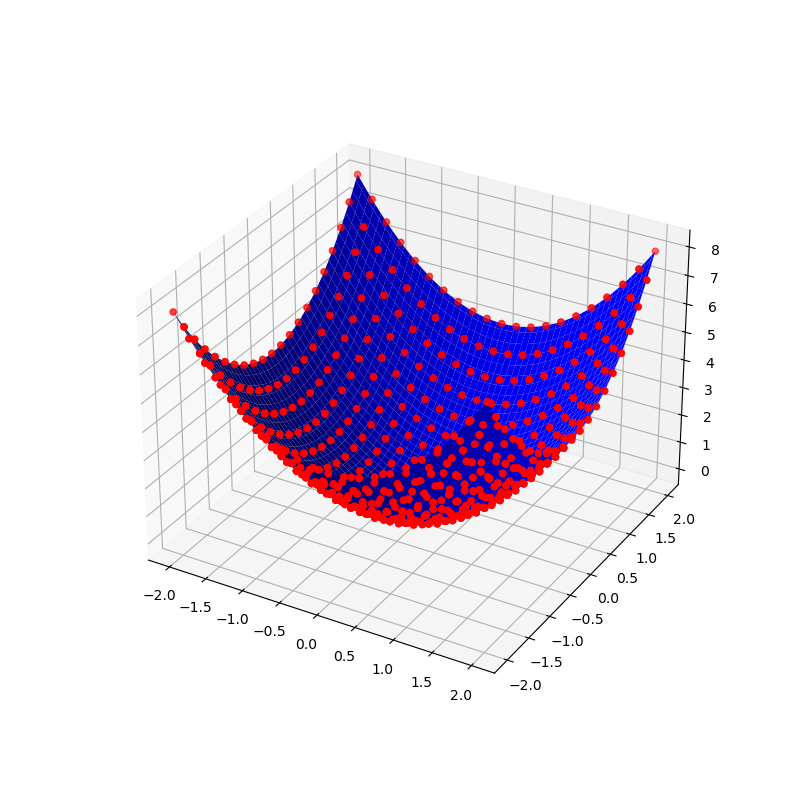

In [29]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, S, color='blue')
ax.scatter(triangles_c[:, 0], triangles_c[:, 1], f(triangles_c[:, 0], triangles_c[:, 1]), color='red')
plt.show()

# $C^0$ quadratic interploation

# $$\boxed{p_{i}(x,y)=\sum_{i=1}^{6}p^{(2)}_{i}f(x_i,y_i)}$$
### where for points of the triangles
$$p^{(2)}_{i}=p^{(1)}_{i}(2p^{(1)}_{i}-1), 1\le i\le3$$ 
### and for middle point of the triangle edges 
$$p^{(2)}_{i}=4p_{i}^{(1)}p_i^{(1)}, 4\le i\le6$$

In [30]:
S = torch.zeros(xx.shape)
p = []
for j in range(3):
    nom = torch.abs(torch.cat((torch.ones(indices[0].shape[0], 3, 1), torch.cat((triangles_s[indices[-1]][:, torch.arange(3)!=j, :], points_[indices[:-1]][:, None]), dim=1)), dim=-1).det())
    tmp = nom / areas[indices[-1]]
    S[indices[:-1]] += f(triangles_s[indices[-1], :, 0], triangles_s[indices[-1], :, 1])[:, j] * tmp*(2*tmp-1)
    p.append(tmp)
pairs = [[j, i] for i in range(3) for j in range(i)]
for pair in pairs:
    middle_points = triangles_s[:, pair].mean(dim=-2)
    S[indices[:-1]] += 4 * p[pair[0]] * p[pair[1]]*f(middle_points[indices[-1], 0], (middle_points[indices[-1], 1]))

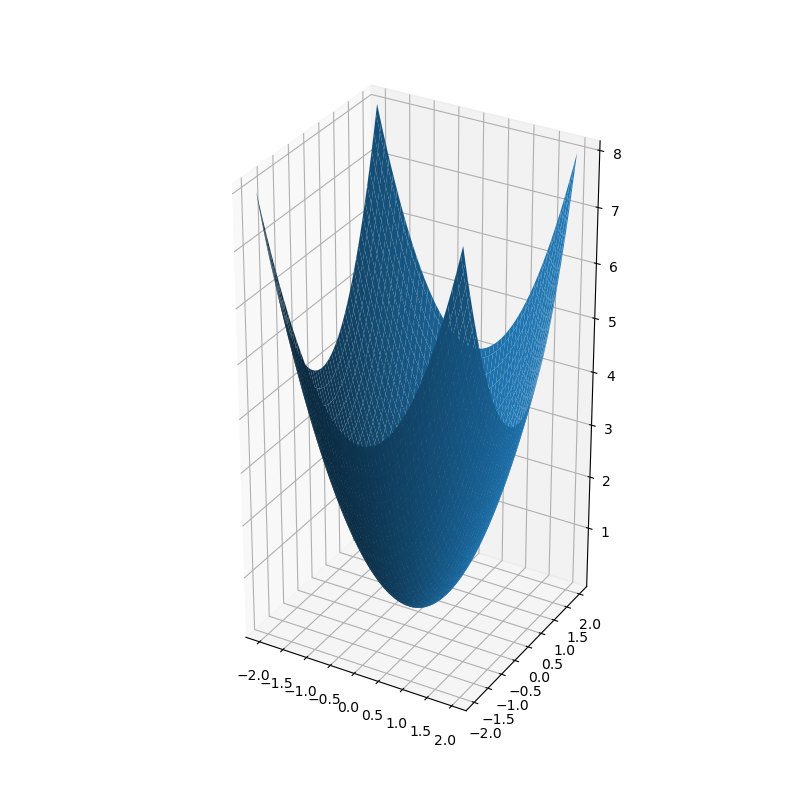

In [31]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
#ax.plot_surface(xx, yy, S, cmap="magma")
k = 0
ax.plot_surface(xx[k:], yy[k:], numpy.diff(S, axis=0, n=k))
ax.set_box_aspect((numpy.ptp(xx), numpy.ptp(yy), numpy.ptp(S)))
#ax.scatter(triangles_c[:, 0], triangles_c[:, 1], f(triangles_c[:, 0], triangles_c[:, 1]), color="red", s=30)
plt.show()

# $C^0$ cubic interpolation

# $$\boxed{p_{i}(x,y)=\frac{1}{S}\sum_{i=1}^{10}p^{(3)}_{i}f(x_i,y_i)}$$
### where for points of the triangles
$$p^{(3)}_{i}=\frac{1}{2} p^{(1)}_{i}(3p^{(1)}_{i}-1)(3p^{(1)}_{i}-2), 1\le i\le3$$ 
### and for trisection point of the triangle edges 
$$p^{(2)}_{i}=\frac{9}{2}p_1p_2(3p_1-1), 4\le i\le9$$
### and for the center point of the triangle
$$p_{10}^{(3)}=27p_1p_2p_3$$

In [32]:
S = torch.zeros(xx.shape)

p = []
for j in range(3):
    nom = torch.abs(torch.cat((torch.ones(indices[0].shape[0], 3, 1), torch.cat((triangles_s[indices[-1]][:, torch.arange(3)!=j, :], points_[indices[:-1]][:, None]), dim=1)), dim=-1).det())
    tmp = nom / areas[indices[-1]]
    S[indices[:-1]] += f(triangles_s[indices[-1], :, 0], triangles_s[indices[-1], :, 1])[:, j] * 0.5 * tmp *(3*tmp-1)*(3*tmp-2)
    p.append(tmp)

pairs = [[j, i] for i in range(3) for j in range(i)]

for pair in pairs:
    
    third_one = 2/3*triangles_s[:, pair[0]] + 1/3*triangles_s[:, pair[1]]
    third_two = 1/3*triangles_s[:, pair[0]] + 2/3*triangles_s[:, pair[1]]

    S[indices[:-1]] += 9/2 * p[pair[0]] * p[pair[1]]*(3*p[pair[0]]-1)*f(third_one[indices[-1], 0], third_one[indices[-1], 1])
    S[indices[:-1]] += 9/2 * p[pair[0]] * p[pair[1]]*(3*p[pair[1]]-1)*f(third_two[indices[-1], 0], third_two[indices[-1], 1])

middle = triangles_s.mean(dim=-2)
S[indices[:-1]] += 27 * p[0]*p[1]*p[2] * f(middle[indices[-1], 0], middle[indices[-1], 1])

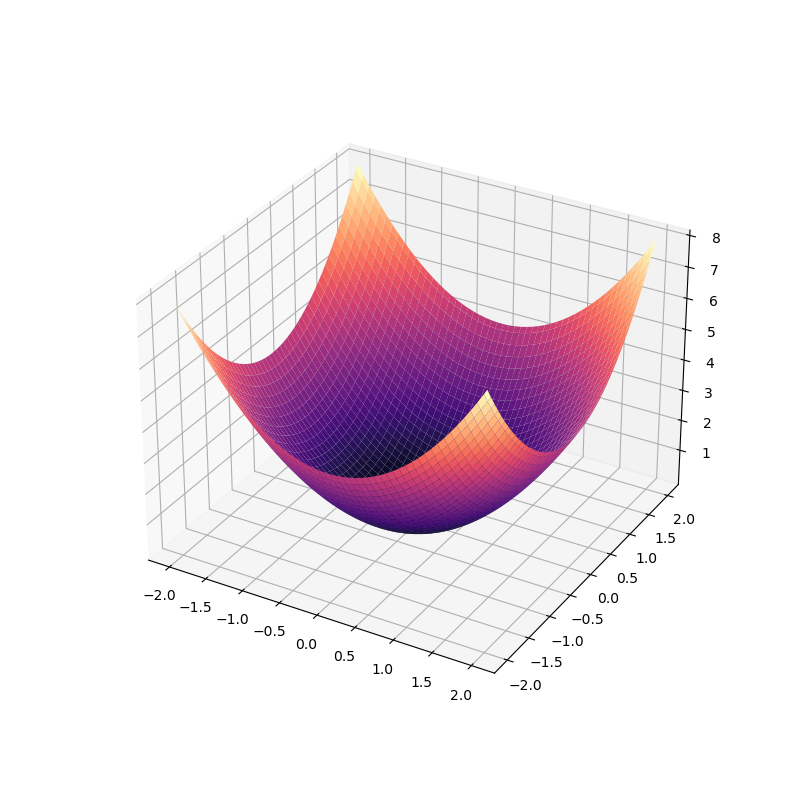

In [33]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', )
k = 0
ax.plot_surface(xx[k:], yy[k:], numpy.diff(S, axis=0, n=k), cmap="magma")
#ax.scatter(XX, YY, f(XX, YY), color='red')
# ax.scatter(triangles_c[:, 0], triangles_c[:, 1], f(triangles_c[:, 0], triangles_c[:, 1]), color="blue", s=30)
plt.show()

# Single basis

In [34]:
y_steps, x_steps = 5, 5
y_start, y_end = -10, 10
x_start, x_end = -10, 10
n_x, n_y = 50, 50
tx = torch.linspace(-10, 10, n_x)
ty = torch.linspace(-10, 10, n_y)
xx, yy = torch.meshgrid(tx, ty, indexing="xy")
zz = torch.zeros(n_y, n_x)

In [35]:
X = torch.linspace(x_start, x_end, x_steps)
Y = torch.linspace(y_start, y_end, y_steps)
h_1 = X.diff()[0]
h_2 = Y.diff()[0]

In [36]:
def phi(X, Y, h1, h2, i, j, n_x, n_y):
    
    tx = torch.linspace(X.min(), X.max(), n_x)
    ty = torch.linspace(Y.min(), Y.max(), n_y)
    
    xx, yy = torch.meshgrid(tx, ty, indexing="xy")
    xm = xx.min()
    ym = yy.min()
    
    xx = xx - ym
    yy = yy - ym
    
    tmp = torch.zeros(xx.shape)
        
    S1 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j >= xx/h1 - i)
    tmp[S1] = (j + 1 - yy/h2)[S1]
    
    S2 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j <= 1 + xx/h1 - i)
    tmp[S2] = (1 + xx/h1 - yy/h2 - i + j)[S2]
    
    S3 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j >= xx/h1 - i)
    tmp[S3] = (1 + xx/h1 - i)[S3]
    
    S4 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j <= xx/h1 - i)
    tmp[S4] = (1 + yy/h2 - j)[S4]
    
    S5 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j >= xx/h1 - i - 1)
    tmp[S5] = (1 - xx/h1 + yy/h2 + i - j)[S5]
    
    S6 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j <= xx/h1 - i)
    tmp[S6] = (1 - xx/h1 + i)[S6]
    
    return tmp

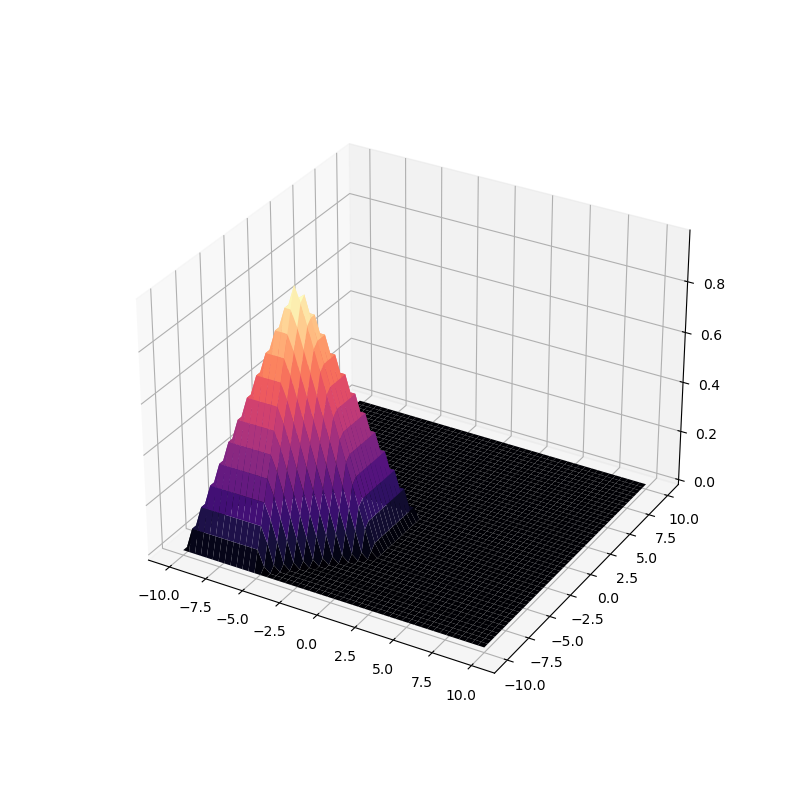

In [37]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, phi(X, Y, h_1, h_2, 1, 1, n_x, n_y), cmap="magma")
plt.show()

# Test

In [38]:
n_x, n_y = 50, 50
tx = torch.linspace(-10, 10, n_x)
ty = torch.linspace(-10, 10, n_y)
xx, yy = torch.meshgrid(tx, ty, indexing="xy")
zz = torch.zeros(n_y, n_x)

for i in range(x_steps):
    for j in range(y_steps):
        zz += phi(X, Y, h_1, h_2, i, j, n_x, n_y)*f(X[i], Y[j])

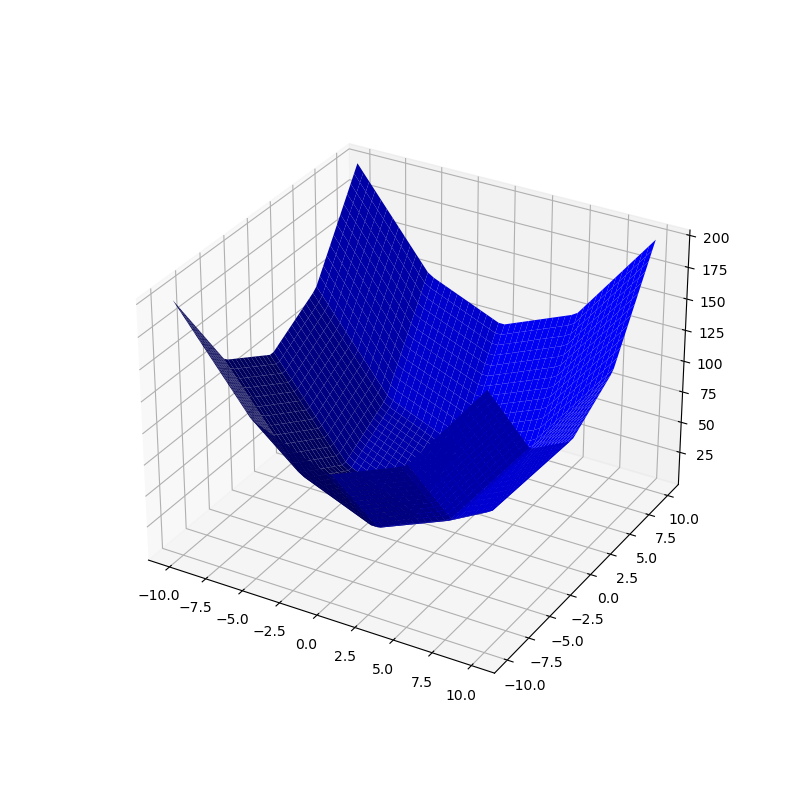

In [39]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz, color='blue')
#ax.scatter(XX, YY, f(XX, YY), color="red", s=100)